# Important Note:
## Need to rum the cells on the bottom
## Training takes a while...need to run when laptop is available for long time processing

Convolutional Neural Nets or Covnets perform well on computer vision problem due to their ability to extract features from local input patches and allowing for representation modularity and data efficiency. This property makes covnets well for sequence processing as well. Time can be treated as a spatial dimensions, like the height or width of a 2D image.

1D covnets can be competitive with RNN's on some sequence-processing problems, usually at a cheaper computational cost. 1D covnets, typically used with dialated kernels have have great sucess with audio generation and machine translation. In addition to its sucesses in these domains, it's been well known that small 1D covnets can offer a fast alternative to RNN''s for simple tasks such as text classification and timeseries forecasting.

## Understanding 1D Convolution for Sequence Data
The convolution layers for images were 2D conovlutions that extracted 2D patches from image tensors and applying an identical transformation to every patch. Similarly, 1D convolutions extract 1D patches, sequences, from sequences.

Convolution layers like this can recognize local patterns in a sequence. Becasue the same input transformation is performed on every pach, a pattern learned at a certain position in a sentence can be recognized at a difference position, making 1D covnets translation invarient. 1D covnets can therefore learn words in any context as an input sequence thus covnets can learn about word morphology.

## 1D Pooling for Sequence Data
Pooling operations such as average pooling and maxpooling were used in covnets to downsample image tensors. The 2D pooling operation has a 1D equivalent: extracting subsequences (patches) from an input and outputting the maxiumum value (max pooling) or average value (average pooling). This operation is also used to reduce the length of the inputs.

In Keras, the 1D covnet is the `Conv1D` layer which takes 3D tensor with shape: (samples, time, features) and returns a similarly shaped 3D tensor. The convolution window is a 1D window on the time axis: in this case 1 as it is a 1D vector.

# 1D Covnet
1D covnets are structured the same way as 2D covnets.  they consist of a stack of `Conv1D` and `MaxPooling1D` layers ending in a global pooling layer or a `Flatten` layer. This flatten layer turns 3D outputs into 2D outputs which allows us to add one or mose `Dense` layers t the model for classification or regression.

An advantage of 1D covnets is we can use larger convolution windows. A 3x3 window in 2D covnets yields 9 features while a window siez of 3 in covents yields 3 features. 

In [7]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# Choose the top n-words from the dataset, and the maximum length of each review|series
max_features = 10000
max_len = 500

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Pad sequences (samples x time)')

# Pad sequences to be the same length incase there are anomolies
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


## Build the network and evaluate

In [9]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
_________________________________________________________________


## Plot the results
We can see that the 1D covnet trains much faster than both LSTM and GRU. However validation accuracy is around 76%.

In [11]:
import matplotlib.pyplot as plt

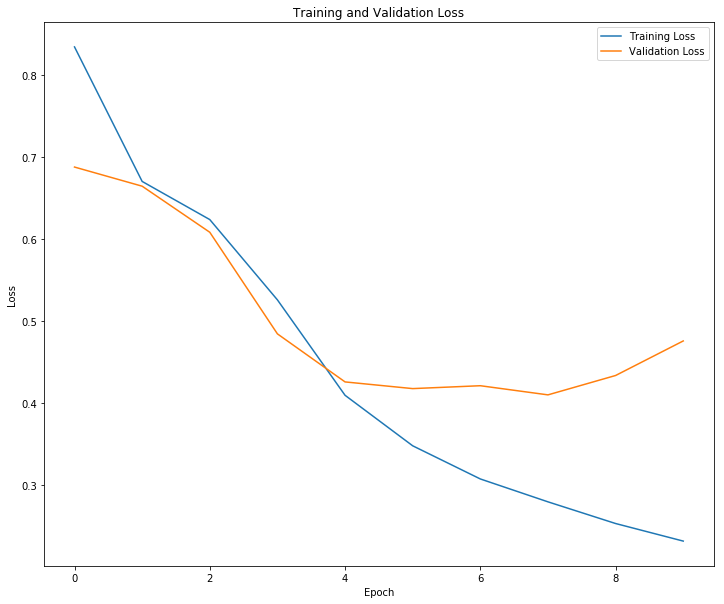

In [15]:
plt.figure(figsize = (12, 10))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Loss')

plt.legend()
plt.show()

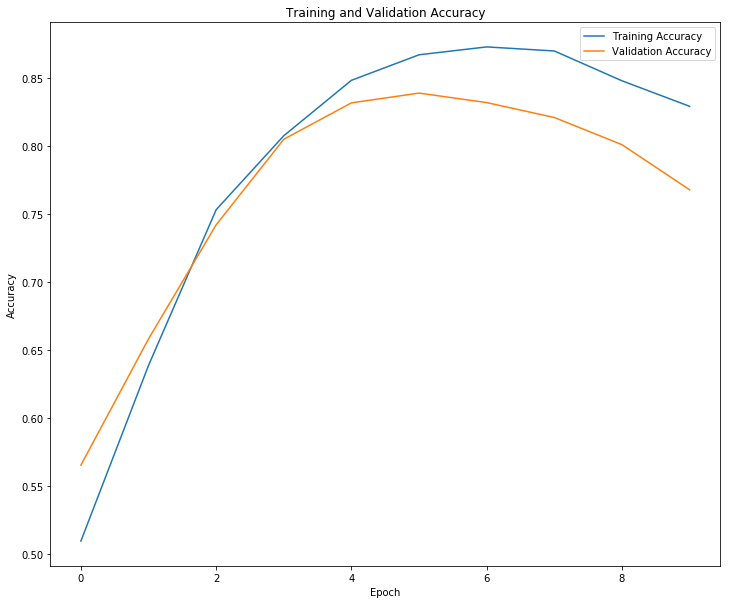

In [14]:
plt.figure(figsize = (12, 10))
plt.plot(history.history['acc'], label = 'Training Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')

plt.legend()

plt.show()

# Combining CNN and RNN to process long sequences
An advantage of 1D covnets is their ability to process input patches independently meaning the are not sensitive to the order of the timesteps.

## Train on Weather Data
The validation MAE is around 0.40 which tells us that this small covnet can't beat the common sense baseline from before which found the temperature 24 hours into the future. The problem arrises fromt he fact that covnets look for patters anywhere in the input timeseries and does not have knowledge of the temporal position of patterns it sees. More recent data points should be interpreted differently from older datapoints. This was not an issue with the IMDB data because the pattern of keywords associated with a postive or negative sentiment are independent if the fact that they're in the input sentences.

In [21]:
import os 

data_dir = '/Users/edenmolina/Documents/AI-Playground/Sequences/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))


import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values
    
# Normalize the Dataset
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

def generator(data, lookback, delay, min_index, max_index,
              shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),
                           lookback // step,
                           data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
    yield samples, targets
    
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)
test_steps = (len(float_data) - 300001 - lookback)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [22]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Epoch 1/20


KeyboardInterrupt: 

A strategy to combind the speed and lightness of covnets with the order-sensitivity of RNN's is to use a 1D covnet as a preprocessing step before using an RNN layer. The 1D CNN would create a shorter sequence that the RNN can take in as input. This is beneficial when working with sequences that are so long (thousands of steps) they can't be processed with RNN's.

Becasue this process allows us to use much longer sequences we can either increase how far back in time the network can see (by increasing the `lookback` parameter) or look at high-resolution timeseries (by decreasing the `step` parameter of the generator). We will arbitarily use a `step` parameter that's half as large resulting in a timeseries that's twice as long, where the temperature data is sample at a rate of 1 point per 30 minutes.

In [23]:
step = 3
lookback = 720
delay = 144

train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200001,
                    max_index=300000,
                    step=step)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step)
val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

In [27]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',
                        input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))
model.summary()
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,
                              steps_per_epoch=5000,
                              epochs = 20,
                              validation_data = val_gen,
                              validation_steps = val_steps)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru_2 (GRU)                  (None, 32)                6240      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 13,697
Trainable params: 13,697
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20


KeyboardInterrupt: 

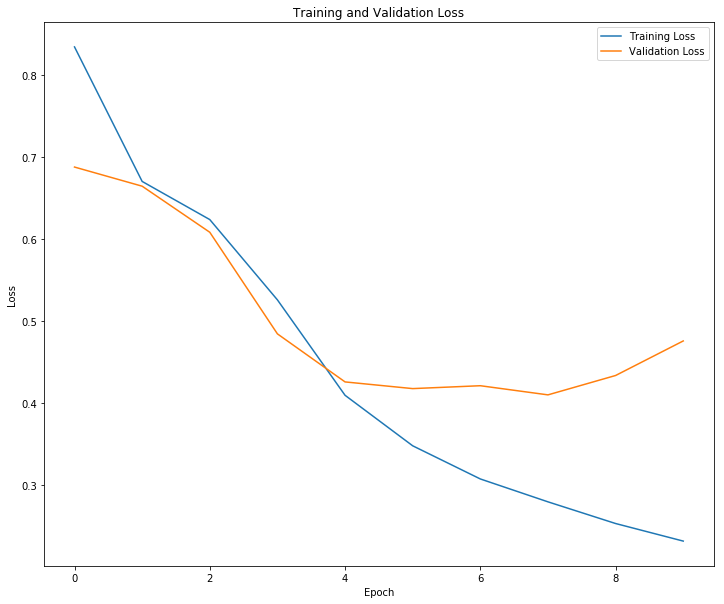

In [25]:
plt.figure(figsize = (12, 10))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.title('Training and Validation Loss')

plt.legend()
plt.show()

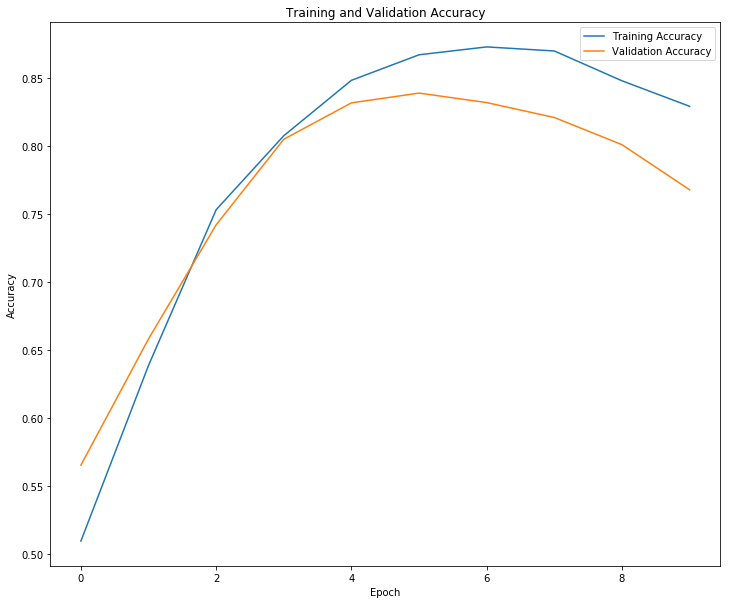

In [26]:
plt.figure(figsize = (12, 10))
plt.plot(history.history['acc'], label = 'Training Accuracy')
plt.plot(history.history['val_acc'], label = 'Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.title('Training and Validation Accuracy')

plt.legend()

plt.show()